In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression

In [3]:
import bias_utils.runs as runs_joint
import bias_utils.single_label as runs_sl
import bias_utils.projects as projects

import importlib
importlib.reload(projects)
importlib.reload(runs_joint)
importlib.reload(runs_sl)

<module 'bias_utils.single_label' from '/nfs/scistore14/alistgrp/eiofinov/pruned_vision_model_bias/bias_utils/single_label.py'>

# Joint Runs Example

This example pulls the information for ResNet18 runs using that prune from random intialization and use the full CelebA dataset.

In [24]:
importlib.reload(runs_joint)

dataset = 'celeba'
arch = 'rn18'
strategy = 'GMP-RI'
structured = False

threshold_adjusted = False

project_name = f"{dataset}-all-{arch}"

pos_fracs_df, neg_fracs_df = runs_joint.compute_pos_neg_matrices(dataset)
runs = runs_joint.get_runs_for_project(project_name, strategy=strategy)

identity_labels = runs_joint.celeba_identity_labels
attr_names = runs_joint.celeba_classes()
runs = [runs_joint.load_run_details(
    run, pos_fracs_df, neg_fracs_df, threshold_adjusted, use_cache=True)
                               for run in runs]
runs = [v for v in runs if 'interdependence' in v]
runs.sort(key=lambda r: (r["sparsity"], r["name"]))

In [25]:
len(runs)

35

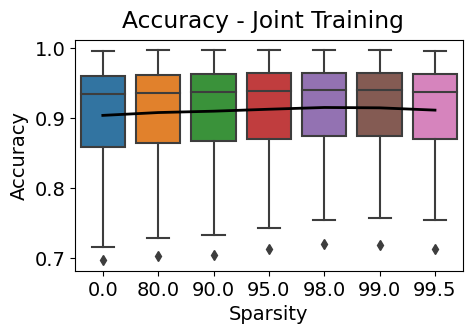

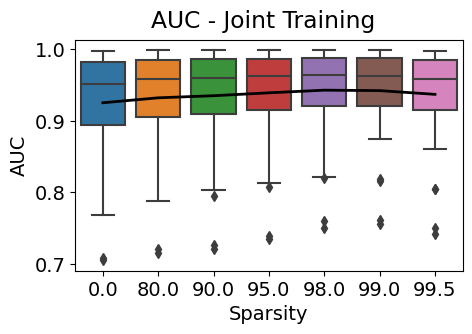

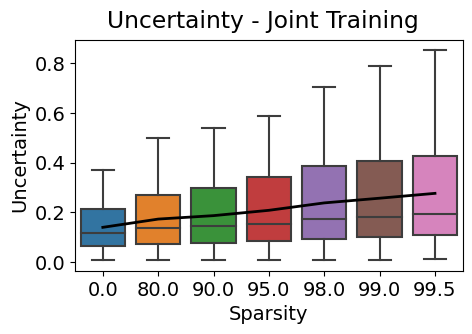

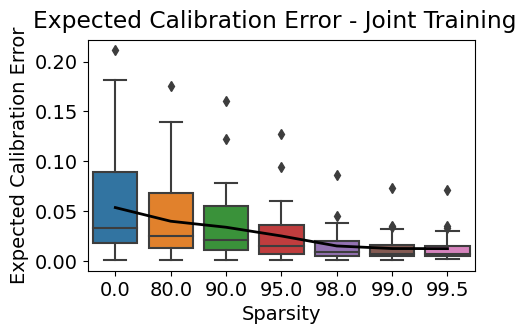

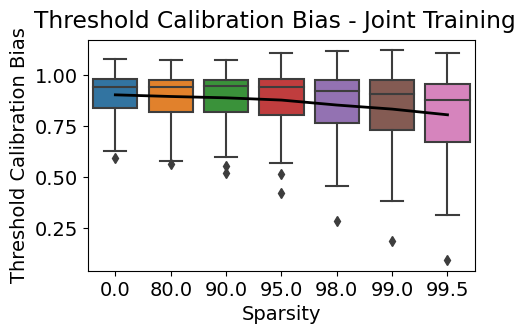

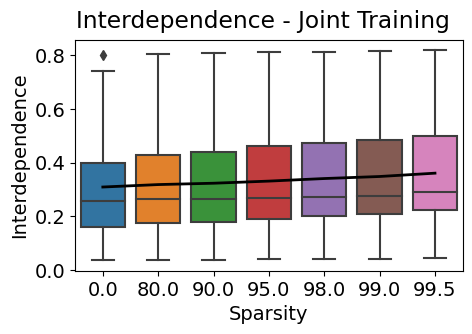

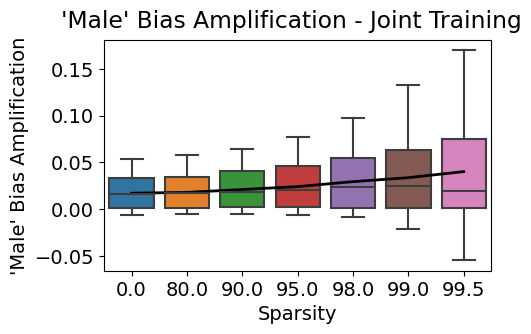

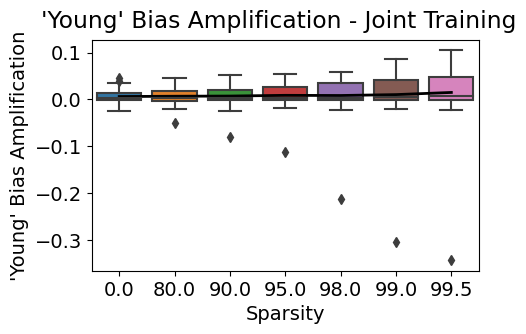

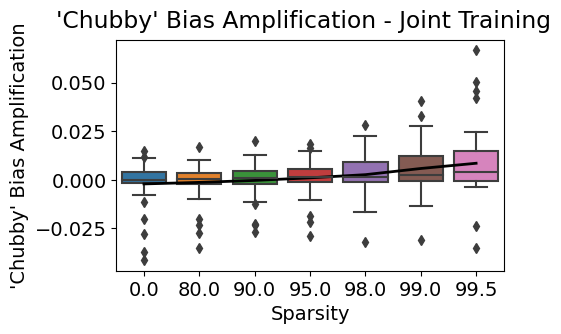

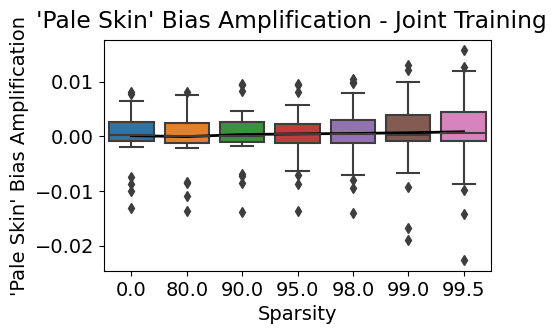

In [26]:
def compute_metric(metric_name, runs):
    dicts = []
    for run in runs:
        for i, attr_name in enumerate(attr_names):
            mydict = {"seed": run["name"],  "sparsity": str(run["sparsity"]),
                      "attr": attr_name, metric_name: run[metric_name][i]}
            dicts.append(mydict)
    df = pd.DataFrame.from_dict(dicts)
    averages_df = df.groupby("sparsity").mean()
    per_attr_avgs = df.groupby(["sparsity", "attr"]).agg("mean").reset_index().pivot(index='sparsity', columns='attr', values=metric_name)
    return df, averages_df, per_attr_avgs

nice_metric_names = {"acc": "Accuracy",
    "auc": "AUC",
    "uncertainty": "Uncertainty",
    "ece": "Expected Calibration Error",
    "rare_val_underpredict": "Threshold Calibration Bias",
    "interdependence": "Interdependence",
    "Male-bas": "'Male' Bias Amplification",
    "Young-bas": "'Young' Bias Amplification",
    "Chubby-bas": "'Chubby' Bias Amplification",
    "Pale_Skin-bas": "'Pale Skin' Bias Amplification",
}

import os
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

def joint_training_boxplot(runs, metric_name, dataset, arch):
    df, averages_df, per_attr_avgs = compute_metric(metric_name, runs)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
    pa_df = per_attr_avgs.copy()
    pa_df.reset_index(inplace=True)
    pa_df = pa_df.melt('sparsity', var_name = "attr", value_name= nice_metric_names[metric_name])
    pa_df.rename(columns={"sparsity": "Sparsity"}, inplace=True)

    sns.boxplot(data=pa_df, x="Sparsity", y=nice_metric_names[metric_name], ax=ax)#.legend_.remove()
    sns.lineplot(data=pa_df, x="Sparsity", y=nice_metric_names[metric_name], ci=None, linewidth = 2,
               color='black',
               ax=ax)
    labels = [item.get_text() for item in ax.get_xticklabels()]

    ax.set_xticklabels(labels)
    fig.suptitle(f"{nice_metric_names[metric_name]} - Joint Training")

    if True:
        os.makedirs("Bias_Paper_Plots", exist_ok=True)
        plt.savefig(f"Bias_Paper_Plots/nm_{dataset}_{arch}_{metric_name}_cotrain_all_{strategy}.pdf")
        plt.savefig(f"Bias_Paper_Plots/nm_{dataset}_{arch}_{metric_name}_cotrain_all_{strategy}.png")
    return [averages_df, per_attr_avgs, df]

stats = {}
for metric_name in nice_metric_names.keys():
    stats[metric_name] = joint_training_boxplot(runs, metric_name, dataset, arch)


In [11]:
# Compute bias amplification in the case that some of the labels
# are overridden by the sparse or dense model. The results will
# be plotted in the next cell.

def compute_override_ba(dense_runs, runs, override_attr_id):
    test_labels = runs_joint.get_test_labels('celeba')
    attr  = attr_names[override_attr_id]
    for run in runs:
        manual_override_bas = []
        dense_override_bas = []
        run[f"{attr}-dense-bas"] = dense_runs[0][f"{attr}-bas"] 
        for relabel_level in [0.025, 0.05, 0.1, 0.15, 0.2]:
            mobas = []
            dobas = []
            for attr_id, attr_name in enumerate(attr_names):
                probs = np.array([dense_run["test_probabilities"][:, attr_id] for dense_run in dense_runs])
                mean_probs = probs.mean(axis=0)
                mean_preds = mean_probs > 0.5
                num_relabel = int(mean_probs.shape[0] * relabel_level)
                ind = np.argpartition(np.abs(mean_probs-0.5), num_relabel)[:num_relabel]
                manual_corrected_test_predictions = run["test_predictions"].copy()
                dense_corrected_test_predictions = run["test_predictions"].copy()
                manual_corrected_test_predictions[ind, attr_id] = test_labels[ind, attr_id]
                dense_corrected_test_predictions[ind, attr_id] = mean_preds[ind]
                mba_post = runs_joint.compute_bias_amplification(test_labels, manual_corrected_test_predictions,
                                              override_attr_id, attr_id,'celeba',pos_fracs_df, neg_fracs_df)
                dba_post = runs_joint.compute_bias_amplification(test_labels, dense_corrected_test_predictions,
                                              override_attr_id, attr_id,'celeba',pos_fracs_df, neg_fracs_df)
        
                if mba_post == None:
                    mba_post = np.nan
                if dba_post == None:
                    dba_post = np.nan
                mobas.append(mba_post)
                dobas.append(dba_post)
                
    
            manual_override_bas.append(mobas)
            dense_override_bas.append(dobas)
        run[f"{attr}_manual_override_bas"] = np.array(manual_override_bas)
        run[f"{attr}_dense_override_bas"] = np.array(dense_override_bas)
    
dense_runs = [r for r in runs if r["sparsity"] == 0]
    

compute_override_ba([dense_runs[-1]], runs, 20)  # Male
compute_override_ba([dense_runs[-1]], runs, 13)  # Chubby
compute_override_ba([dense_runs[-1]], runs, 39)  # Pale_Skin
compute_override_ba([dense_runs[-1]], runs, 26)  # Young


too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute Wearing_

too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 1.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 1.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small fo

too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small fo

too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
too few positive examples for attribute Rosy_Cheeks
predictions 0.0
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute

too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 1.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 1.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribu

too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few negative examples for attribute Sideburns
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 0.0
too few negative examples for attribu

too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small fo

too few positive examples for attribute Rosy_Cheeks
predictions 0.0
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small fo

too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute

too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribu

too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few negative examples for attribute Sideburns
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 3.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 0.0
too few negative examples for attribu

too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small fo

too few positive examples for attribute Rosy_Cheeks
predictions 0.0
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small fo

too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
too few positive examples for attribute Rosy_Cheeks
predictions 0.0
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Si

too few positive examples for attribute Rosy_Cheeks
predictions 0.0
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small fo

too few negative examples for attribute Bald
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
too few positive examples for attribute Rosy_Cheeks
predictions 0.0
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock

too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few negative examples for attribute Sideburns
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 3.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock

too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribu

too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
too few positive examples for attribute Rosy_Cheeks
predictions 0.0
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribu

too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Goatee
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
too few negative examples for attribute Mustache
predictions 0.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
too few positive examples for attribute Rosy_Cheeks
predictions 0.0
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Sideburns
predictions 0.0
too few negative examples for attribute Wearing_Necktie
predictions 1.0
too few negative examples for attribute Wearing_Necktie
predictions 2.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute 5_o_Clock_Shadow
predictions 0.0
too few negative examples for attribute Bald
predictions 1.0
too few negative examples for attribu

Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows

Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows

Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows

Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows

Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Bushy_Eyebrows
Diff is too small for attribute Big_Lips
Diff is too small for attribute Big_Lips
Diff is too small for attribute Black_Hair
Diff is too small for attribute Black_Hair
Diff is too small for attribute Bushy_Eyebrows

Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small 

Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff

Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff

Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff

Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff

Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff

Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff

Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff is too small for attribute Smiling
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute 5_o_Clock_Shadow
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute High_Cheekbones
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Mouth_Slightly_Open
Diff is too small for attribute Smiling
Diff

too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 2.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 5.0
too few positive examples for attribute Rosy_Cheeks
predictions 5.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive ex

Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 2.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 8.0
too few positive examples for attribute Rosy_Cheeks
predictions 8.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute

too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

too few positive examples for attribute Goatee
predictions 3.0
too few positive examples for attribute Goatee
predictions 3.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 4.0
too few positive examples for attribute Rosy_Cheeks
predictions 5.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 3.0
too few positive 

too few positive examples for attribute Goatee
predictions 3.0
too few positive examples for attribute Goatee
predictions 3.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

too few positive examples for attribute Goatee
predictions 2.0
too few positive examples for attribute Goatee
predictions 2.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Rosy_Cheeks
predictions 4.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 6.0
too few positive examples for attribute Rosy_Cheeks
predictions 7.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Rosy_Cheeks
predictions 4.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 5.0
too few positive 

too few positive examples for attribute Goatee
predictions 3.0
too few positive examples for attribute Goatee
predictions 3.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Rosy_Cheeks
predictions 4.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Rosy_Cheeks
predictions 4.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 2.0
too few positive examples for attribute Mustache
predictions 4.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 1.0
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Rosy_Cheeks
predictions 4.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive examples for attribute Mustache
predictions 1.0
too few positive examples for attribute Mustache
predictions 3.0
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Narrow_Eyes
Diff is too small for attribute Pointy_Nose
Diff is too small for attribute Pointy_Nose
too few positive examples for attribute Rosy_Cheeks
predictions 2.0
too few positive examples for attribute Rosy_Cheeks
predictions 3.0
too few positive examples for attribute Sideburns
predictions 6.0
too few positive examples for attribute Sideburns
predictions 6.0
Diff is too small for attribute Wearing_Necklace
Diff is too small for attribute Wearing_Necklace
too few positive examples for attribute Bald
predictions 9.0
too few positive examples for attribute Bald
predictions 4.0
too few positive examples for attribute Goatee
predictions 4.0
too few positive 

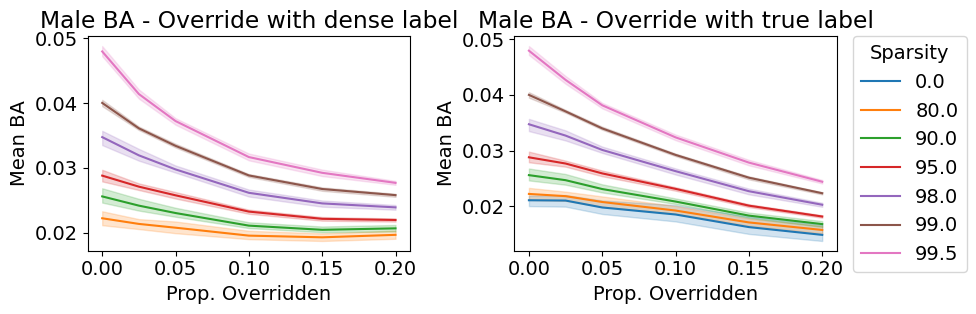

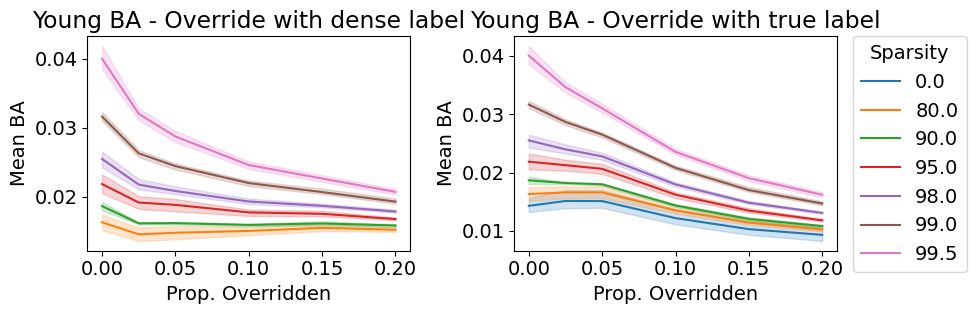

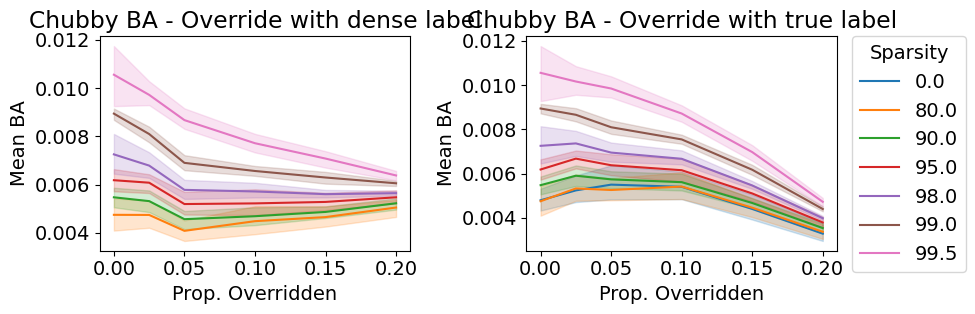

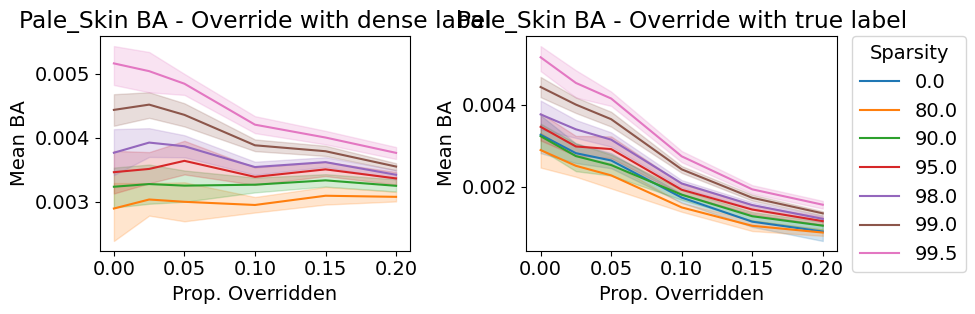

In [12]:
def plot_effect(kind, ax, attr):
    dicts= []
    for run in runs:
        if (kind == "dense_override" and run['sparsity'] == 0):
            continue
        for i, attr_name in enumerate(attr_names):
            if run[f"{attr}-dense-bas"][i] > 0.0:
                mydict = {"seed": run["name"],  "sparsity": str(run["sparsity"]),
                    "strategy": run["strategy"],
                    "attr": attr_name,
                    0: run[f"{attr}-bas"][i],
                    0.025: run[f"{attr}_{kind}_bas"][0,i],
                    0.05: run[f"{attr}_{kind}_bas"][1,i],
                    0.1: run[f"{attr}_{kind}_bas"][2,i],
                    0.15: run[f"{attr}_{kind}_bas"][3,i],
                    0.2: run[f"{attr}_{kind}_bas"][4,i],
                    }
                dicts.append(mydict)

    df = pd.DataFrame.from_dict(dicts)
    df = df.melt(["seed", "sparsity", "strategy", "attr"],
               var_name='Prop. Overridden', value_name=f'Mean BA')
    df = df.groupby(["seed", "sparsity", "Prop. Overridden"]).agg("mean")
    df = df.sort_values("sparsity")
    df.reset_index(inplace=True)
  
    if kind == 'manual_override':
        palette=[sns.color_palette()[0]]+sns.color_palette()[1:7]
    else:
        palette=sns.color_palette()[1:7]
  
    if kind == "dense_override":
        g = sns.lineplot(data = df, x="Prop. Overridden",
                         y=f"Mean BA", hue="sparsity", ax=ax,
               palette=palette, legend=False)
    else:
        sns.lineplot(data = df, x="Prop. Overridden", y=f"Mean BA", hue="sparsity", ax=ax,
               palette=palette)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Sparsity")#,
              #labels=["Dense", "2:4", "1:4", "1:8"])
    
    
    nice_kind = kind.replace("_", " ").capitalize()

    return(df)

for attr in ["Male", "Young", "Chubby", "Pale_Skin"]:
    fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
    dfs = []
    for i, override_type in enumerate(["manual_override", "dense_override"]):
        dfs.append(plot_effect(override_type, ax[1-i], attr))
    ax[1].set_title(f"{attr} BA - Override with true label")
    ax[0].set_title(f"{attr} BA - Override with dense label")

    fig.tight_layout(rect=[0, 0.03, 1, 0.99])
    os.makedirs("Bias_Paper_Plots/fixes", exist_ok=True)
    plt.savefig(f"Bias_Paper_Plots/fixes/{attr}_{arch}_{strategy}_override_improvements.pdf")
    plt.savefig(f"Bias_Paper_Plots/fixes/{attr}_{arch}_{strategy}_override_improvements.png")




In [13]:
# Find the Compression-identified exemplars at each sparsity.

test_labels = runs_joint.get_test_labels(dataset)

def get_cies(runs, attr_id, sparsity):
    attr = runs_joint.celeba_classes()[attr_id]
    if "Shadow" in attr:
        attr = "Five_OClock_Shadow"
    test_labels_df = pd.DataFrame(test_labels)
    test_labels_df.reset_index(inplace=True)
    test_labels_df.columns = ["example_id"] + [f"{attr_name}_label" for  attr_name in attr_names]

    # Look for CIEs
    dicts = []
    for run in runs:
        mydict = {"seed": run["name"], "type": run["type"], \
            "strategy": run["strategy"], "sparsity": run["sparsity"]}
        mydict["example_id"] = [i for i in range(run["test_outputs"].shape[0])]

        mydict[f"{attr}_prediction"] = run["test_predictions"][:,attr_id] 

        mydict[f"{attr}_prob"] = run["test_probabilities"][:,attr_id] 
        mydict[f"{attr}_uncertainty"] = np.abs(run["test_probabilities"][:,attr_id] -0.5) < 0.4 
        run_df = pd.DataFrame(mydict)
        del(mydict)
        dicts.append(run_df)
    runs_df = pd.concat(dicts, ignore_index=True)
    del(dicts)

    groupers = {f"{attr_name}_prediction": "mean" for attr_name in [attr]}
    groupers = {**groupers,
            **{f"{attr_name}_prob": [np.mean, np.std] for attr_name in [attr]},
            **{f"{attr_name}_uncertainty": "mean" for attr_name in [attr]},
            }
    grouped = runs_df.groupby(['strategy', 'sparsity', 'example_id']).agg(groupers)
    del(runs_df)
    grouped.reset_index(inplace=True)
    for attr_name in [attr]:
        grouped[f'{attr_name}_prediction'] = grouped[f'{attr_name}_prediction'] > 0.5 
    grouped.columns = grouped.columns.map('_'.join).str.strip('_')
    dense_grouped = grouped[grouped.sparsity==0]
    sparse_grouped = grouped[grouped.sparsity==sparsity]
    combined = pd.merge(dense_grouped, sparse_grouped, on='example_id')
    uncertain = {}
    high_level = []
    for attr_name in [attr]:
        if "Shadow" in attr_name:
            attr = "Five_OClock_Shadow"
        disagreements = combined.query(f"{attr_name}_prediction_mean_x != {attr_name}_prediction_mean_y")
        annotated = pd.merge(disagreements, test_labels_df, on='example_id', how='left') 

        high_level.append({
            "attr_name": attr_name,
            "sparsity": sparsity,
            "pie_prop_uncertain_dense": disagreements[f"{attr_name}_uncertainty_mean_x"].mean(), 
            "pie_prop_uncertain_dense_std": disagreements[f"{attr_name}_uncertainty_mean_x"].std(), 
            "prop_uncertain_dense": dense_grouped[f"{attr_name}_uncertainty_mean"].mean(),
            "prop_uncertain_dense_std": dense_grouped[f"{attr_name}_uncertainty_mean"].std(),
    

            "num_pies" : len(disagreements),
            "prop_pos_to_neg" : (disagreements[f"{attr_name}_prediction_mean_x"] > disagreements[f"{attr_name}_prediction_mean_y"]).mean() 
                })
        uncertain[attr_name] = annotated

    return pd.DataFrame(high_level)


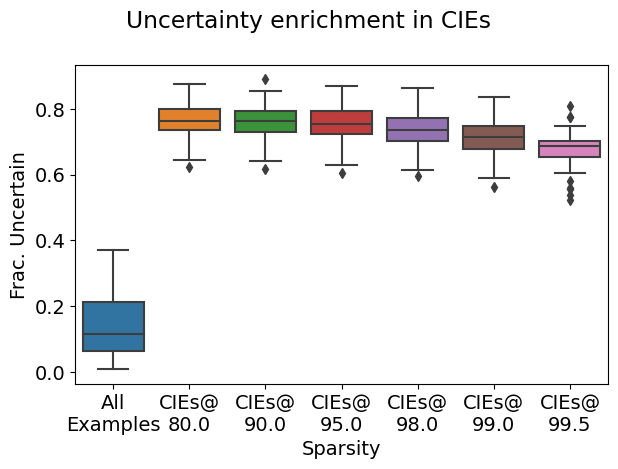

In [19]:
#dfs = [get_cies(runs, attr_id, sp) for attr_id in range(40) for sp in [80, 90, 95, 98, 99, 99.5]]

def plot_cie_fraction(dfs, dataset, arch, suffix=""):
    cies = pd.concat(dfs)
    cies["Sparsity"] = "CIEs@\n"+cies["sparsity"].astype(str)
    cies["Frac. Uncertain"] = cies["pie_prop_uncertain_dense"]
    uncies = cies[cies["sparsity"] == 80].copy()
    uncies["Frac. Uncertain"] = uncies["prop_uncertain_dense"]
    uncies["Sparsity"] = "All\nExamples"
    merged = pd.concat([uncies, cies])

    fig, ax = plt.subplots()
    sns.boxplot(data=merged, x="Sparsity", y="Frac. Uncertain", ax=ax)
    labels = [item.get_text() for item in ax.get_xticklabels()]

    ax.set_xticklabels(labels)
    fig.suptitle("Uncertainty enrichment in CIEs")
    fig.tight_layout()
    if True:
        os.makedirs("Bias_Paper_Plots/", exist_ok=True)
        plt.savefig(f"Bias_Paper_Plots/cie_uncertainty_enrichment_{dataset}_{arch}{suffix}.pdf")
        plt.savefig(f"Bias_Paper_Plots/cie_uncertainty_enrichment_{dataset}_{arch}{suffix}.png")

plot_cie_fraction(dfs, dataset, arch)

In [27]:
# Compute all relevant run stats
# in the case that the +/- threshold is calibrated on the validation set.

threshold_adjusted = True

project_name = f"{dataset}-all-{arch}"

pos_fracs_df, neg_fracs_df = runs_joint.compute_pos_neg_matrices(dataset)
ta_runs = runs_joint.get_runs_for_project(project_name, strategy=strategy)
#print(ta_runs)

ta_runs = [runs_joint.load_run_details(
   run, pos_fracs_df, neg_fracs_df, threshold_adjusted, use_cache=True)
                              for run in ta_runs]
ta_runs = [v for v in ta_runs if 'interdependence' in v]
ta_runs.sort(key=lambda r: (r["sparsity"], r["name"]))

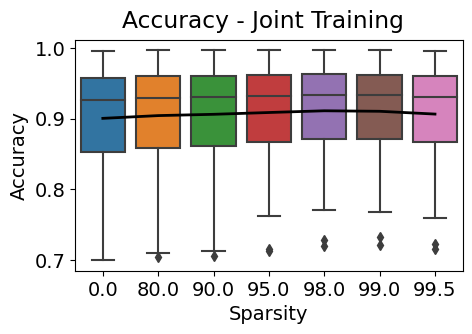

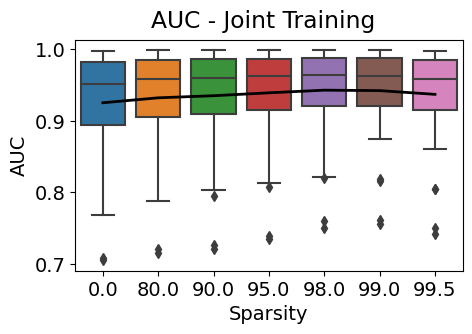

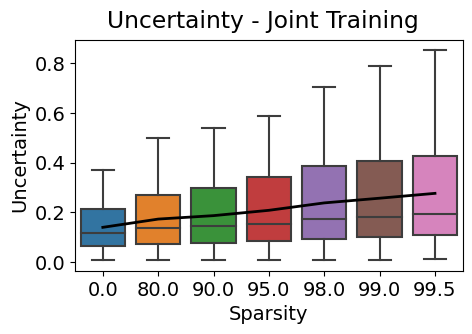

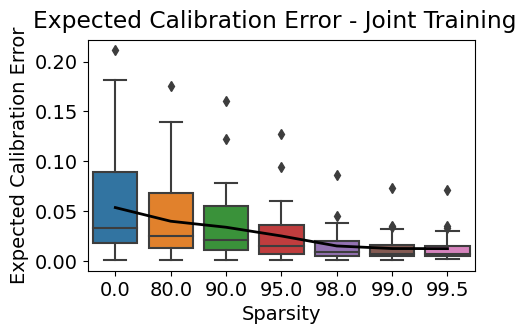

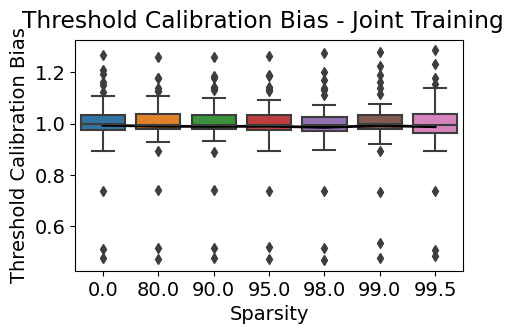

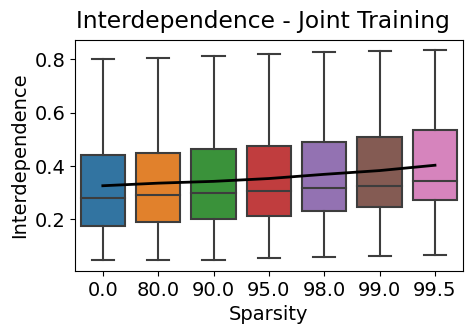

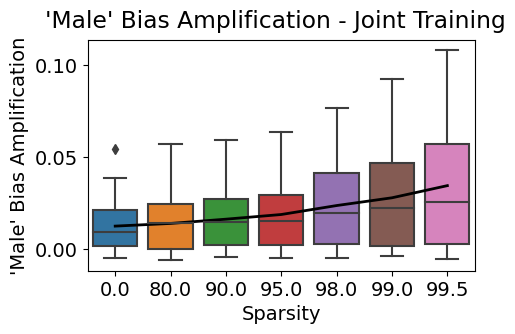

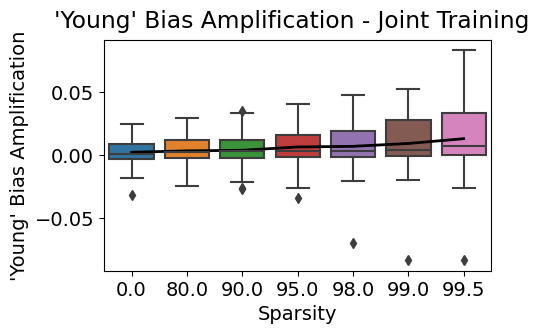

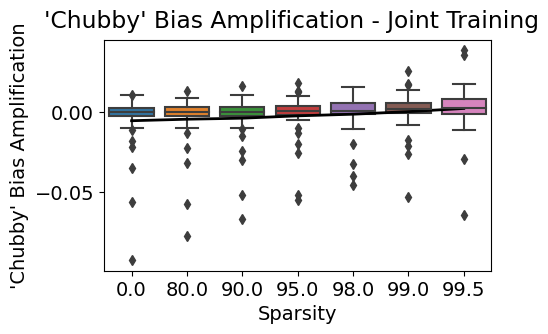

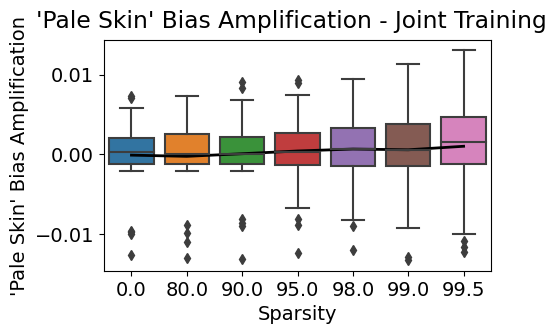

In [28]:
ta_stats = {}
for metric_name in nice_metric_names.keys():
    ta_stats[metric_name] = joint_training_boxplot(ta_runs, metric_name, dataset, arch)


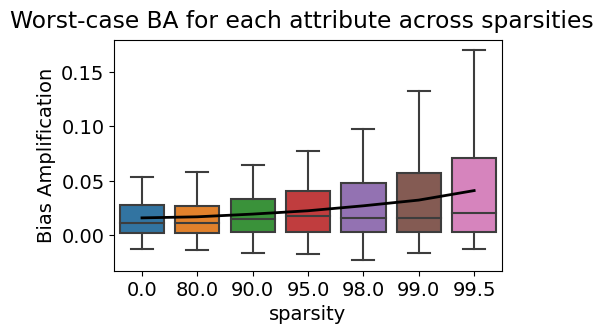

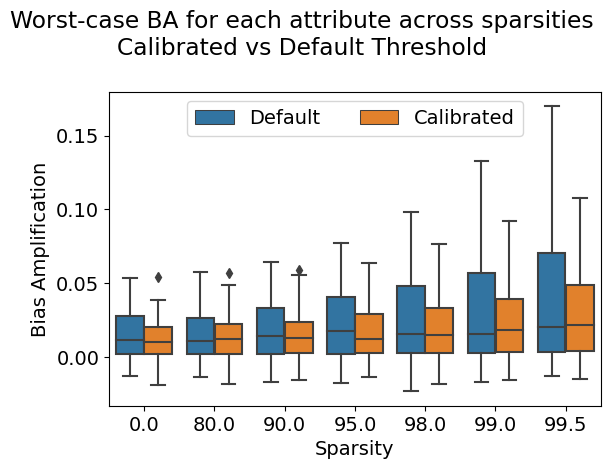

In [17]:
# Plot the impact of threshold adjustment on the bias amplifications

maxes = []
max_vals = np.zeros_like(ta_stats["Male-bas"][1])
iattrs = ["Male", "Young", "Chubby", "Pale_Skin"]
for attr_id, attr_name in enumerate(attr_names):
    attr_bas = [stats[f"{iattr}-bas"][1][attr_name] for iattr in iattrs]
    max_idx = np.nanargmax(attr_bas, axis=0)
    for i in range(max_idx.shape[0]):
        max_vals[i][attr_id] = stats[f"{iattrs[max_idx[i]]}-bas"][1][attr_name].values[i]
maxBA = pd.DataFrame(max_vals)
maxBA.index=stats["Male-bas"][1].index
maxBA.columns=stats["Male-bas"][1].columns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
fig.suptitle("Worst-case BA for each attribute across sparsities")
sns.boxplot(data=maxBA.transpose(), ax=ax)
mdf = maxBA.transpose().reset_index().melt("attr", var_name="sparsity", value_name="Bias Amplification")
sns.lineplot(data=mdf, x='sparsity', y='Bias Amplification', ci=None, linewidth = 2, color='black',  ax=ax)


mdf = maxBA.transpose().reset_index().melt("attr", var_name="sparsity", value_name="Bias Amplification")
if True:
    os.makedirs("Bias_Paper_Plots", exist_ok=True)
    plt.savefig(f"Bias_Paper_Plots/{dataset}_{arch}_{strategy}_worst_case_ba_boxplot.pdf")
    plt.savefig(f"Bias_Paper_Plots/{dataset}_{arch}_{strategy}_worst_case_ba_boxplot.png")


maxes = []
max_vals = np.zeros_like(ta_stats["Male-bas"][1])
iattrs = ["Male", "Young", "Chubby", "Pale_Skin"]
for attr_id, attr_name in enumerate(attr_names):
    attr_bas = [ta_stats[f"{iattr}-bas"][1][attr_name] for iattr in iattrs]
    max_idx = np.nanargmax(attr_bas, axis=0)
    for i in range(max_idx.shape[0]):
        max_vals[i][attr_id] = ta_stats[f"{iattrs[max_idx[i]]}-bas"][1][attr_name].values[i]
df = pd.DataFrame(max_vals)
df.index=ta_stats["Male-bas"][1].index
df.columns=ta_stats["Male-bas"][1].columns
df = df.transpose()

df.reset_index(inplace=True)
df = df.melt('attr', var_name='Sparsity', value_name='Bias Amplification')
df["Threshold-Adjusted"] = "Calibrated"
odf = maxBA.transpose()
odf.reset_index(inplace=True)
odf = odf.melt('attr', var_name='Sparsity', value_name='Bias Amplification')
odf["Threshold-Adjusted"] = "Default"
df = pd.concat([odf, df])

fig, ax = plt.subplots(nrows=1, ncols=1)

sns.boxplot(data=df, x="Sparsity", y="Bias Amplification", hue='Threshold-Adjusted', ax=ax)

fig.suptitle("Worst-case BA for each attribute across sparsities\nCalibrated vs Default Threshold")
ax.legend(loc='upper center',  ncol=2)
fig.tight_layout()

if True:
    os.makedirs("Bias_Paper_Plots", exist_ok=True)
    plt.savefig(f"Bias_Paper_Plots/threshold_adj_{dataset}_{arch}_{strategy}_worst_case_ba_boxplot.pdf")
    plt.savefig(f"Bias_Paper_Plots/threshold_adj_{dataset}_{arch}_{strategy}_worst_case_ba_boxplot.png")


# Single Label

In [29]:
importlib.reload(runs_sl)
importlib.reload(runs_joint)
test_labels = runs_sl.get_test_labels()
pos_fracs_df, neg_fracs_df = runs_joint.compute_pos_neg_matrices('celeba')

single_runs = runs_sl.get_runs_for_project_single('celeba-single-rn18')
single_runs = runs_sl.get_run_summaries(single_runs, 'celeba', backdoor=False, use_cache=True)

./runs/single_label_runs/celeba/resnet18/Dense/mustache/0/seed_17
./runs/single_label_runs/celeba/resnet18/Dense/mustache/0/seed_19
./runs/single_label_runs/celeba/resnet18/Dense/mustache/0/seed_21
./runs/single_label_runs/celeba/resnet18/Dense/mustache/0/seed_23
./runs/single_label_runs/celeba/resnet18/Dense/mustache/0/seed_15
./runs/single_label_runs/celeba/resnet18/GMP-RI/mustache/80/seed_15
./runs/single_label_runs/celeba/resnet18/GMP-RI/mustache/80/seed_23
./runs/single_label_runs/celeba/resnet18/GMP-RI/mustache/80/seed_21
./runs/single_label_runs/celeba/resnet18/GMP-RI/mustache/80/seed_19
./runs/single_label_runs/celeba/resnet18/GMP-RI/mustache/80/seed_17
./runs/single_label_runs/celeba/resnet18/GMP-RI/mustache/995/seed_19
./runs/single_label_runs/celeba/resnet18/GMP-RI/mustache/995/seed_21
./runs/single_label_runs/celeba/resnet18/GMP-RI/mustache/995/seed_17
./runs/single_label_runs/celeba/resnet18/GMP-RI/mustache/995/seed_15
./runs/single_label_runs/celeba/resnet18/GMP-RI/mustac

Mustache
mustache


/nfs/scistore14/alistgrp/eiofinov/anaconda3/envs/torch18/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/nfs/scistore14/alistgrp/eiofinov/anaconda3/envs/torch18/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/nfs/scistore14/alistgrp/eiofinov/anaconda3/envs/torch18/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/nfs/scistore14/alistgrp/eiofinov/anaconda3/envs/torch18/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


Blond_Hair
blond
Receding_Hairline
receding-hairline


/tmp/ipykernel_3568112/4182195744.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))


Big_Nose
big-nose
Smiling
smiling


/nfs/scistore14/alistgrp/eiofinov/anaconda3/envs/torch18/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/nfs/scistore14/alistgrp/eiofinov/anaconda3/envs/torch18/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


Oval_Face
oval-face
Bags_Under_Eyes
bags-under-eyes


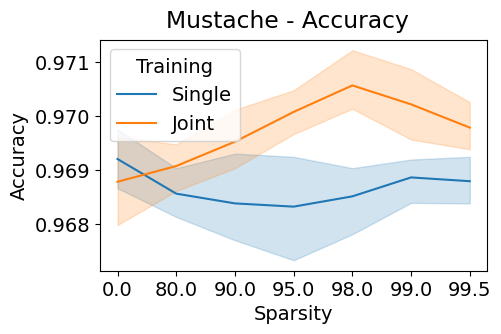

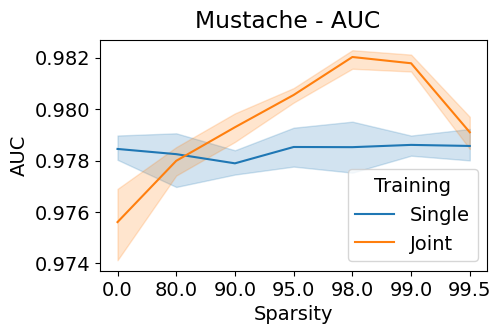

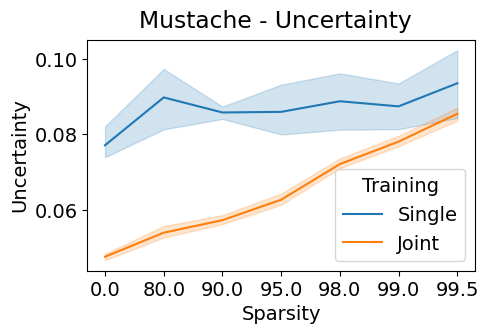

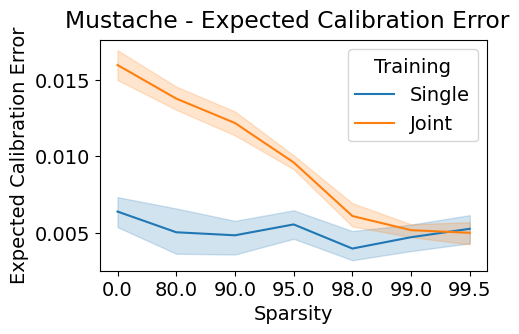

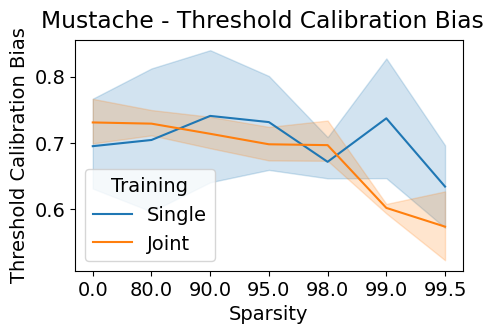

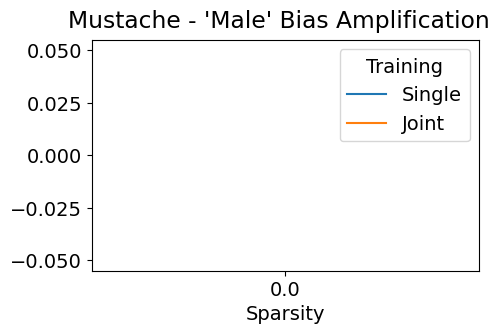

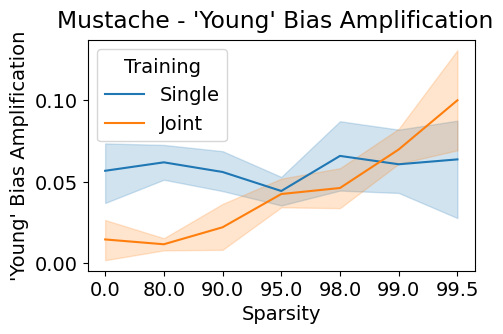

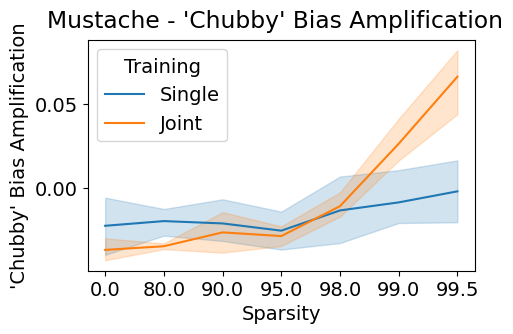

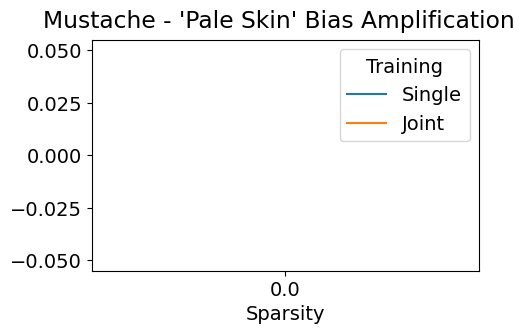

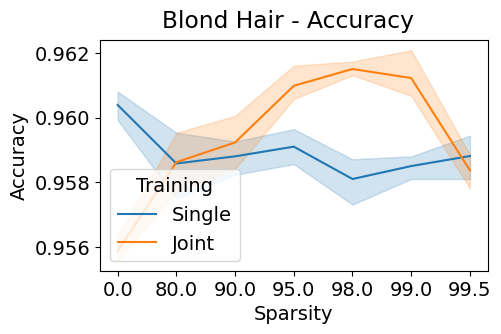

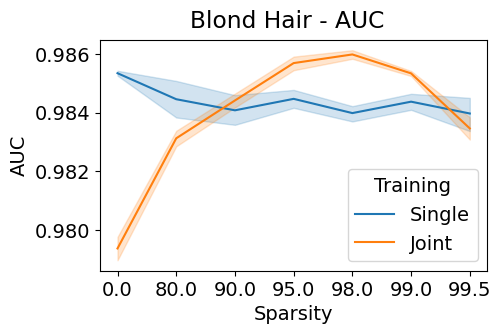

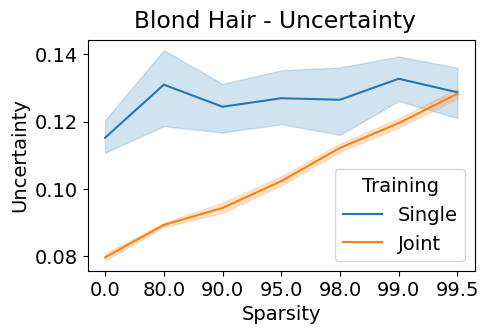

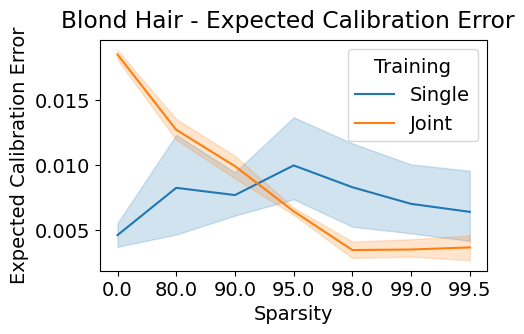

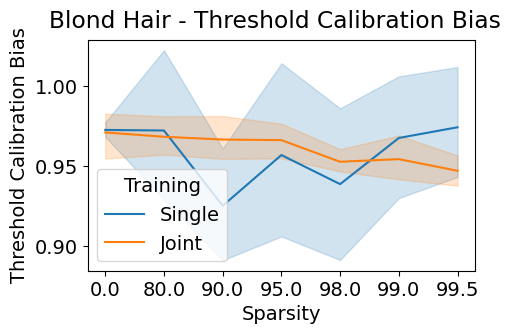

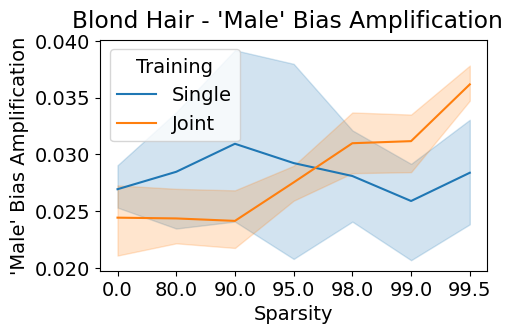

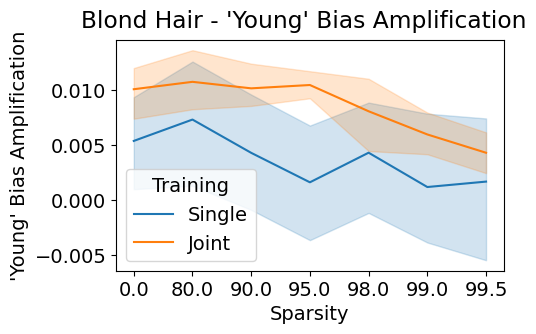

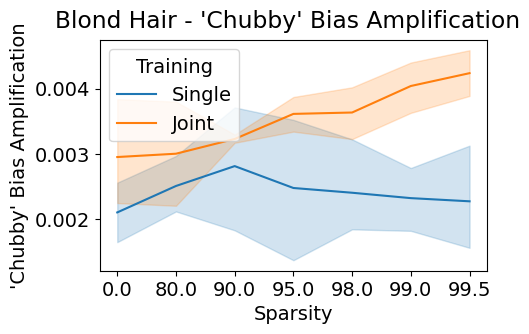

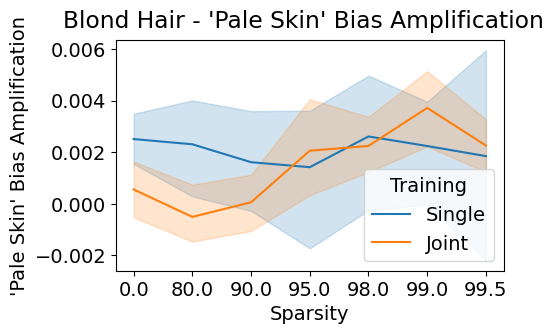

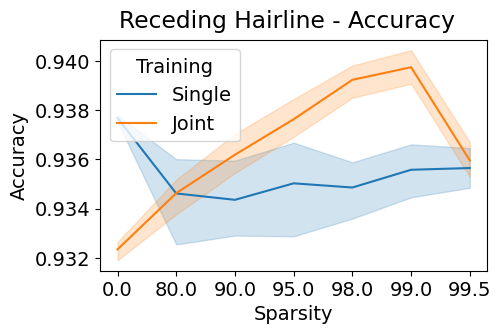

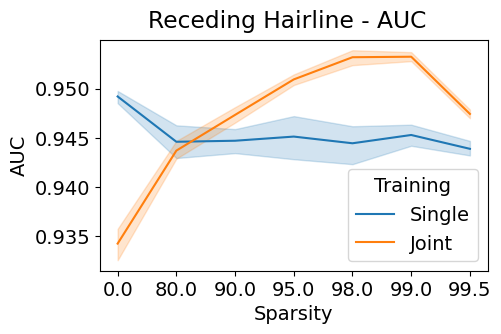

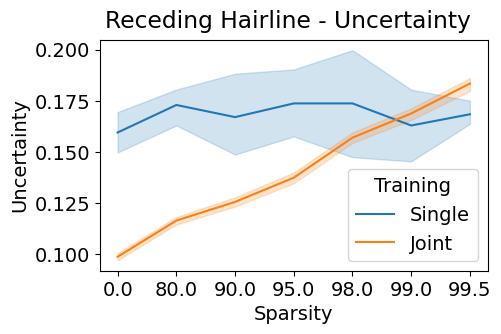

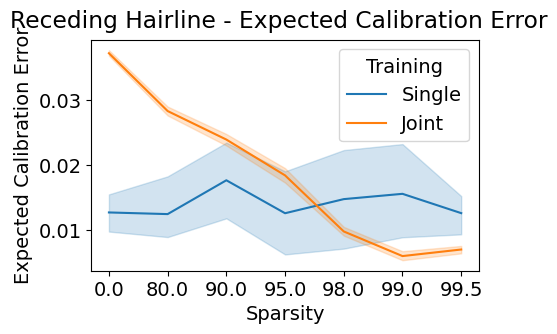

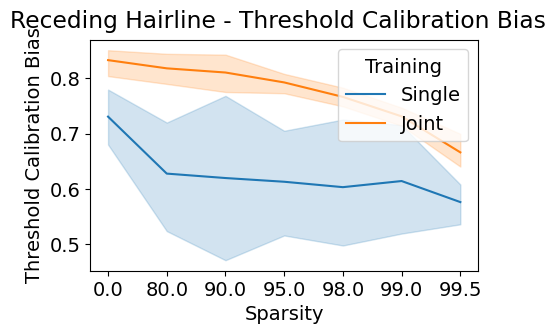

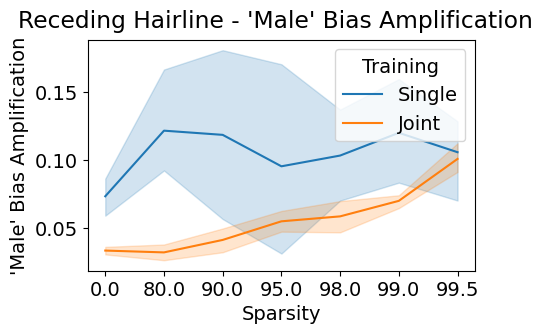

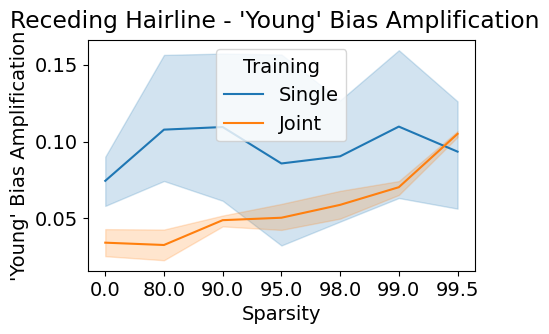

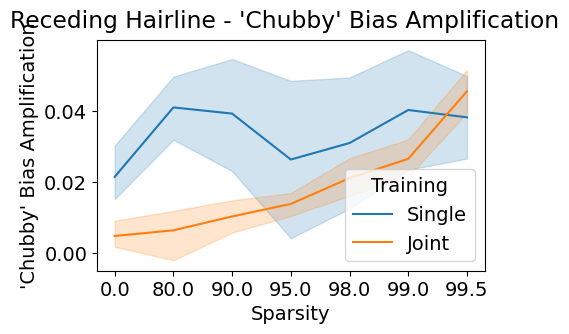

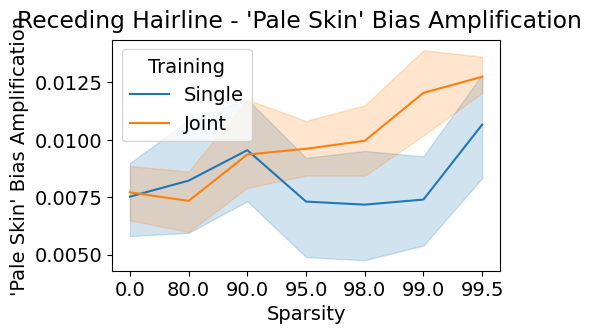

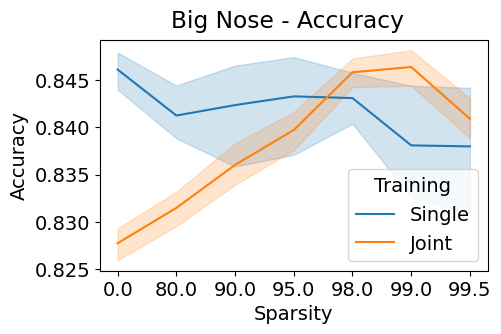

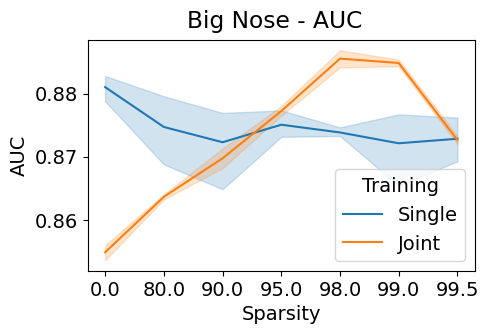

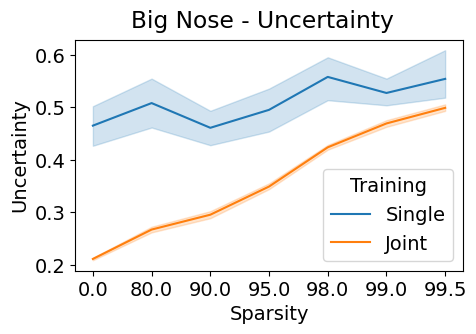

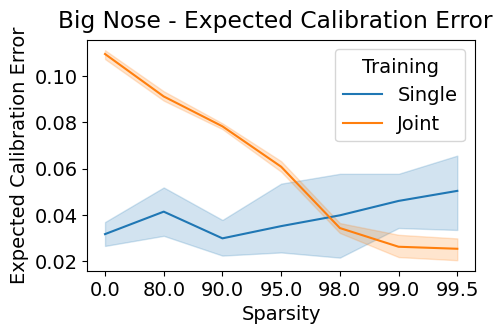

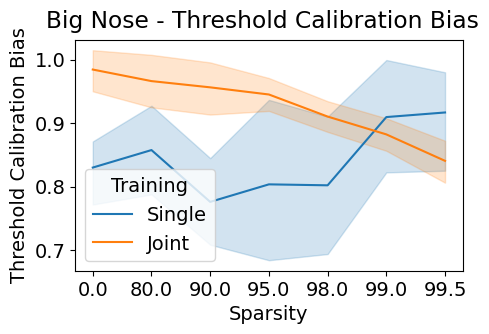

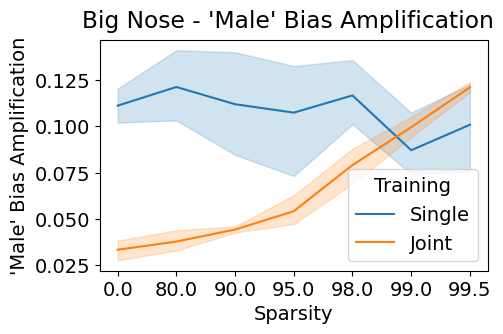

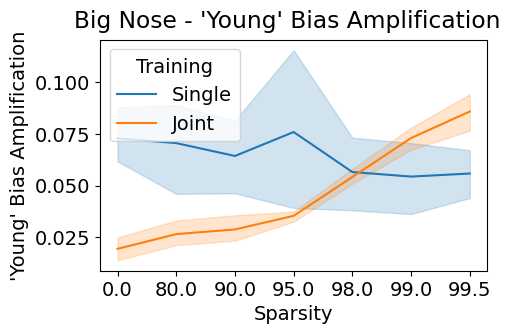

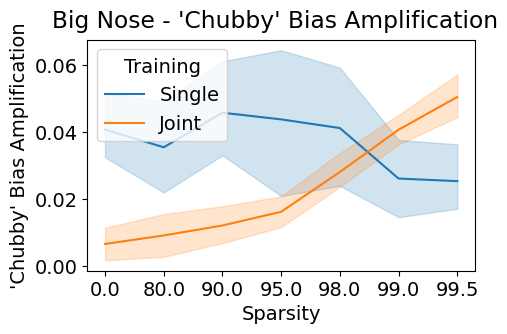

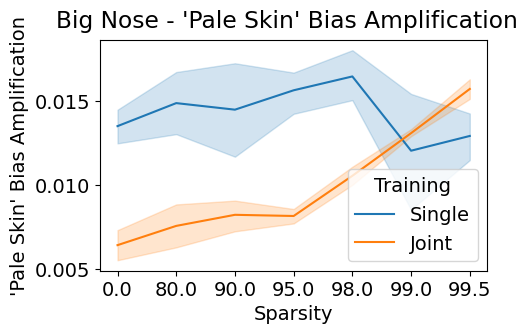

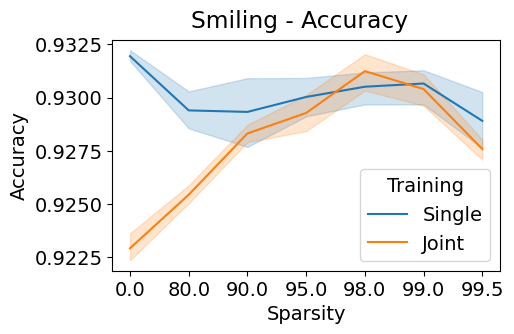

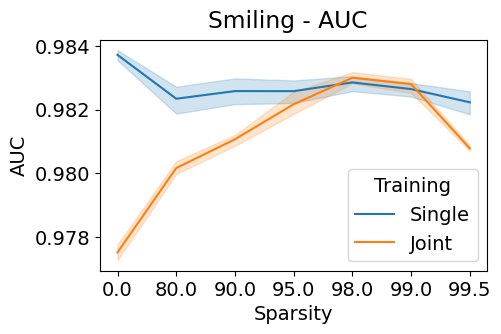

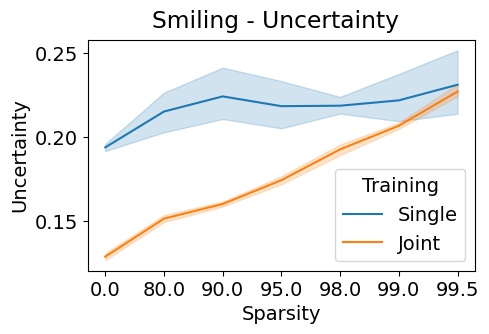

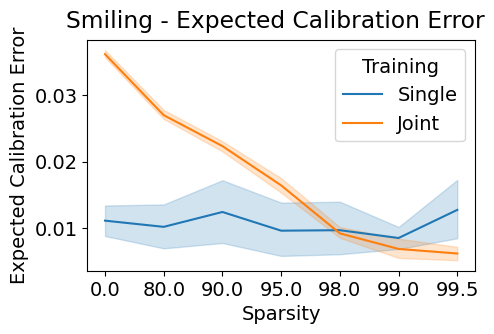

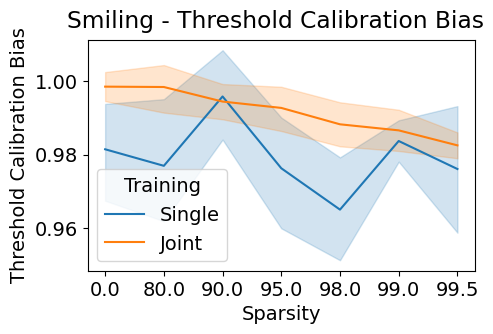

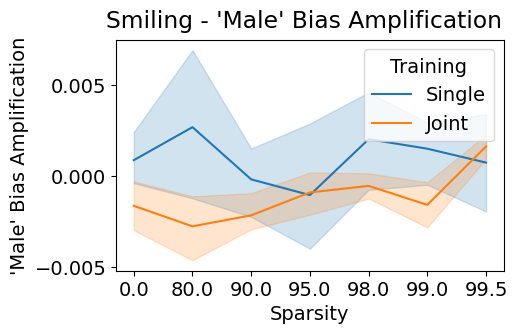

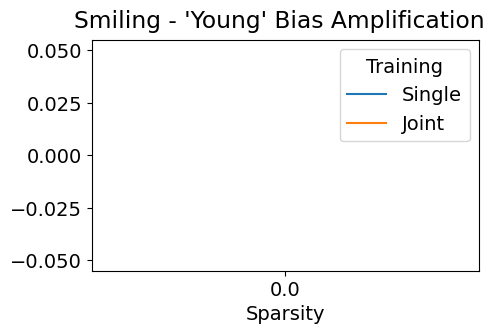

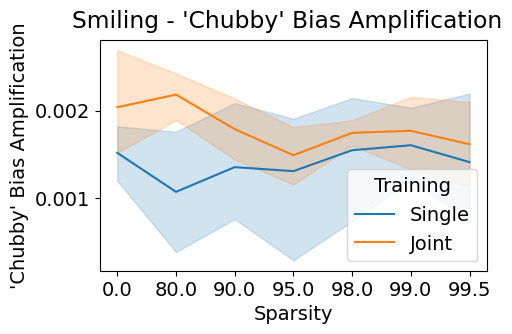

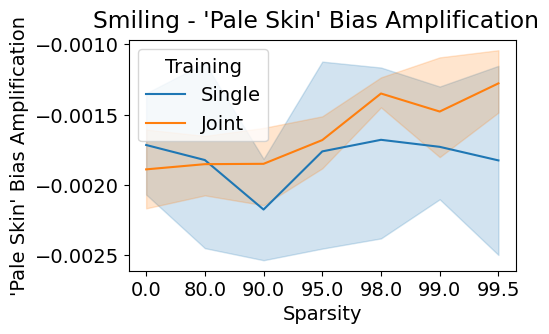

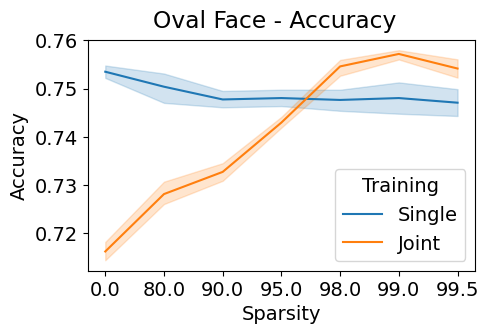

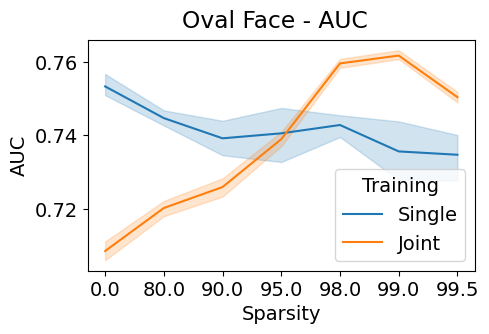

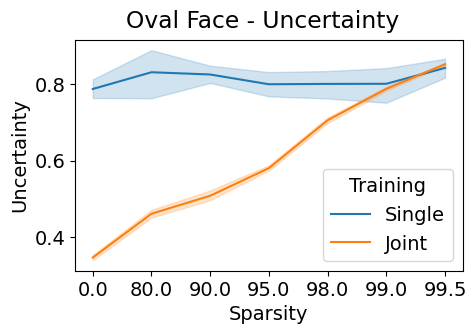

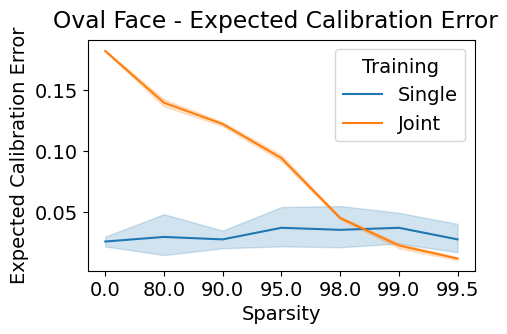

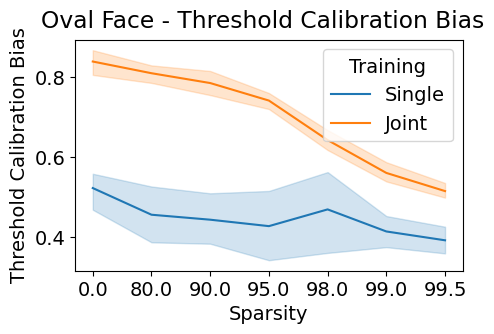

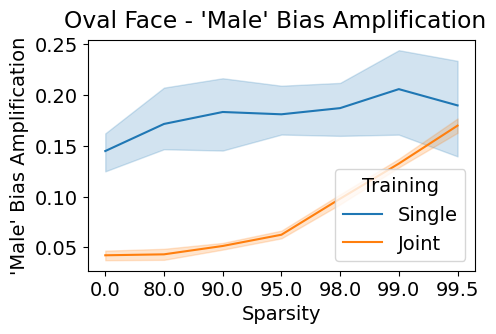

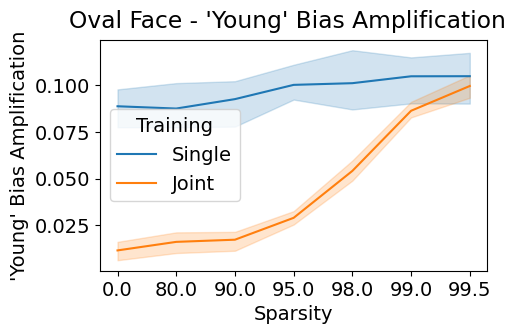

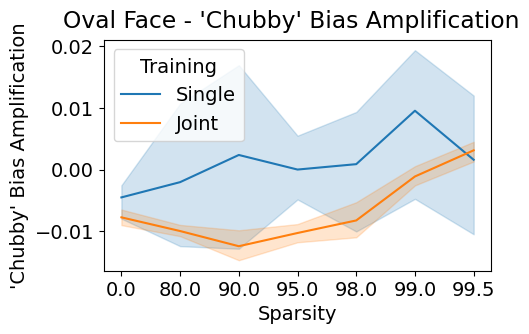

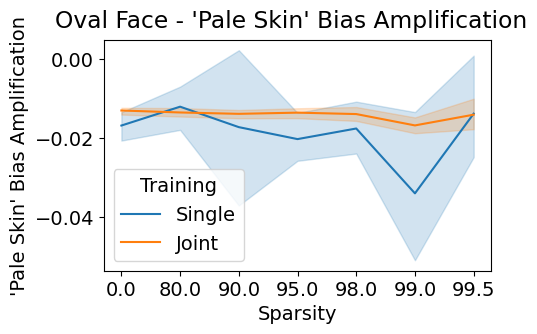

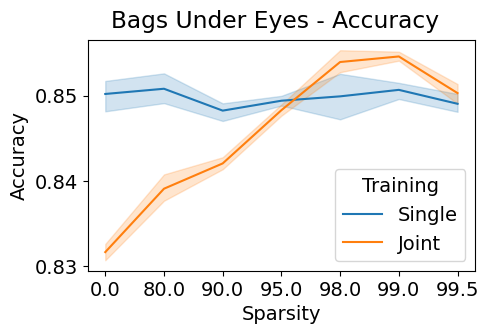

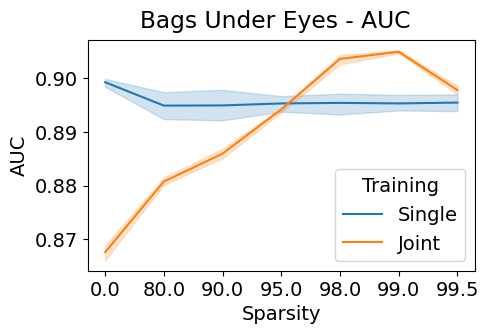

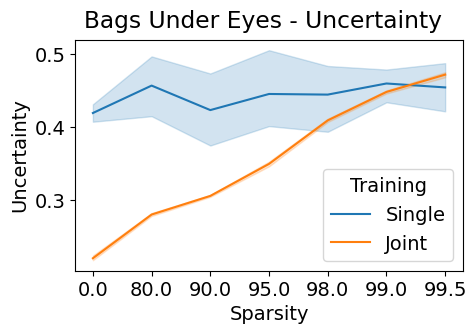

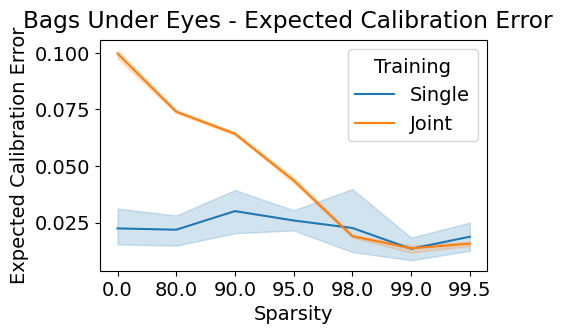

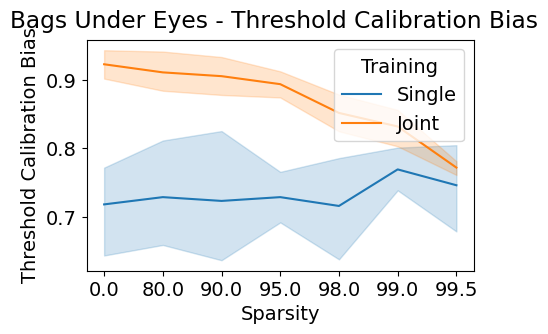

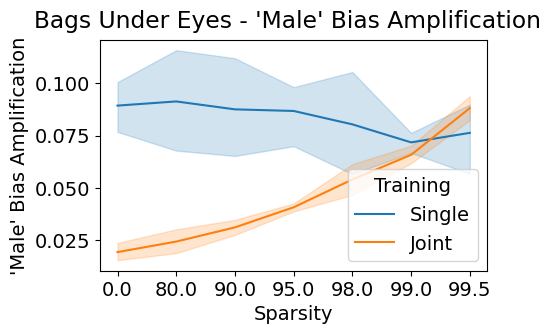

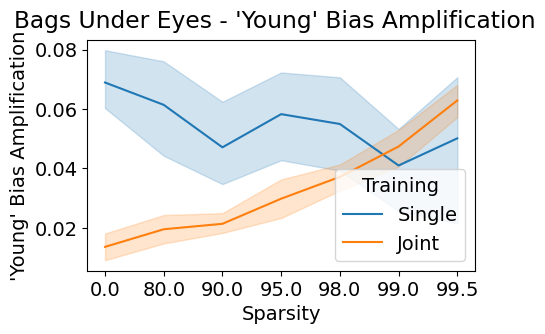

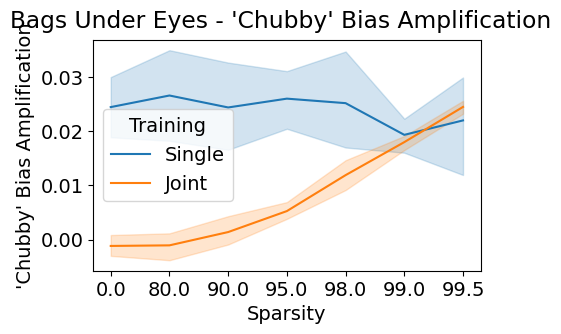

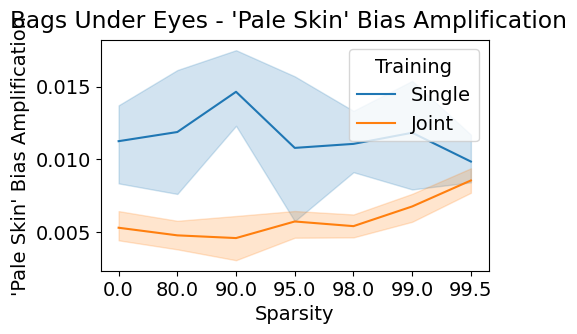

In [30]:
nice_metric_names = {"acc": "Accuracy",
    "auc": "AUC",
    "uncertainty": "Uncertainty",
    "ece": "Expected Calibration Error",
    "rare_val_underpredict": "Threshold Calibration Bias",
    "interdependence": "Interdependence",
    "Male-bas": "'Male' Bias Amplification",
    "Young-bas": "'Young' Bias Amplification",
    "Chubby-bas": "'Chubby' Bias Amplification",
    "Pale_Skin-bas": "'Pale Skin' Bias Amplification",
}

def compute_metric(metric_name, runs, attr_id = None):
    dicts = []
    for run in runs:
        if "test_outputs" not in run:
            print(f"!!!! Dropping run, {run['run_dir']}")
            continue
        if attr_id:
            mydict = {"seed": run["name"], "type": run["type"], "sparsity": str(run["sparsity"]),
                  metric_name: run[metric_name][attr_id]}
        else:
            mydict = {"seed": run["name"], "type": run["type"], "sparsity": str(run["sparsity"]),
                  metric_name: run[metric_name]}
        dicts.append(mydict)
    df = pd.DataFrame.from_dict(dicts)
    averages_df = df.groupby("type").mean()
    return df, averages_df



attrs_dict = {'blond': 9, 
                  'smiling':31,
                  'oval-face': 25,
                  'oval_face': 25,
                  'big-nose': 7,
                  'big_nose': 7,
                  'big_lips': 6,
                  'mustache': 22,
                  'receding-hairline': 28,
                  'receding_hairline': 28,
                  'bags-under-eyes': 3,
                  'wearing_necktie': 38,
                  'attractive': 2,
                  'male': 20,
                  'young': 39
                 }

from sklearn import metrics
targets = runs_joint.get_test_labels(dataset)

def compute_uncertainty_calibration(run, attr):
    run["test_pred_prob"] = 1/(1 + np.exp(-run["test_outputs"]))
    run["test_pred_prob_bucket"] = np.floor(run["test_pred_prob"]*10)/10
    df = pd.DataFrame({"bucket": run["test_pred_prob_bucket"], "pred":run["test_pred_prob"], "label": test_labels[:,attrs_dict[attr]] })
    df = df.groupby("bucket").agg(["mean", "count"])
    total = df["pred", "count"].sum()
    run["ece"] = (np.abs(df["pred", "mean"] -df["label"]["mean"])*df["pred"]["count"]/total).sum()
    return run

def compute_uncertainty_auc_underpredict(run, attr):
    if run["sparsity"] == 995:
        run["sparsity"] = 99.5
    run["test_pred_prob"] = 1/(1 + np.exp(-run["test_outputs"]))
    run["uncertainty"] = (np.abs(run["test_pred_prob"]-0.5) < 0.4).mean()
    run["high_uncertainty"] = (np.abs(run["test_pred_prob"]-0.5) < 0.1).mean()
    fpr1, tpr1, thresholds = metrics.roc_curve(targets[:, attrs_dict[attr]], run["test_pred_prob"], pos_label=1)
    run["auc"] = metrics.auc(fpr1, tpr1)
    run["rare_val_underpredict"] = run["test_predictions"].mean()/targets[:, attrs_dict[attr]].mean()
    return run

single_stats = {}
for i, (attr, attr_runs) in enumerate(single_runs.items()):
    single_stats[attr] = {}
    attr_id = attrs_dict[attr]
    print(attr_names[attr_id])
    attr_runs = [compute_uncertainty_calibration(run, attr) for run in attr_runs]
    attr_runs = [compute_uncertainty_auc_underpredict(run, attr) for run in attr_runs]
    joint_runs = runs
    attr_runs.sort(key=lambda x: x["sparsity"])
    print(attr)
    for metric_name in ("acc", "auc", "uncertainty",
                      "ece",
                      "rare_val_underpredict",
                      "Male-bas", "Young-bas", "Chubby-bas", "Pale_Skin-bas"
                     ):
        df, averages_df = compute_metric(metric_name, attr_runs)
        df["Training"] = "Single"
        joint_df, joint_averages_df = compute_metric(metric_name, joint_runs, attr_id)
        joint_df["Training"] = "Joint"
        df = pd.concat([df, joint_df], ignore_index=True)
        df.rename(columns={metric_name: nice_metric_names[metric_name], "sparsity": "Sparsity"}, inplace=True)
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
        single_stats[attr][metric_name] = [df, averages_df]
        sns.lineplot(data=df, x="Sparsity", hue="Training", y=nice_metric_names[metric_name], ax=ax)
        nice_attr_name = runs_joint.celeba_classes()[attrs_dict[attr]].replace("_", " ")
        fig.suptitle(f"{nice_attr_name} - {nice_metric_names[metric_name]}")
        fig.tight_layout#(rect=[0, 0.03, 1, 0.9])

        if False:
            os.makedirs("Bias_Paper_Plots/single_label", exist_ok=True)
            plt.savefig(f"Bias_Paper_Plots/single_label/{dataset}_{arch}_{attr}_{metric_name}_single.pdf")

# Backdoored runs

In [31]:
importlib.reload(runs_sl)
backdoor_runs = runs_sl.get_runs_for_project_backdoor('celeba-backdoor-single-rn18')
backdoor_runs = runs_sl.get_run_summaries(backdoor_runs, 'celeba', backdoor=True, use_cache=True)

./runs/backdoor_runs/celeba/resnet18/Dense/oval-face/grayscale/0/seed_35
./runs/backdoor_runs/celeba/resnet18/Dense/oval-face/grayscale/0/seed_8
./runs/backdoor_runs/celeba/resnet18/Dense/oval-face/grayscale/0/seed_15
./runs/backdoor_runs/celeba/resnet18/Dense/oval-face/grayscale/0/seed_23
./runs/backdoor_runs/celeba/resnet18/Dense/oval-face/grayscale/0/seed_30
./runs/backdoor_runs/celeba/resnet18/Dense/oval-face/yellow_square/0/seed_30
./runs/backdoor_runs/celeba/resnet18/Dense/oval-face/yellow_square/0/seed_23
./runs/backdoor_runs/celeba/resnet18/Dense/oval-face/yellow_square/0/seed_8
./runs/backdoor_runs/celeba/resnet18/Dense/oval-face/yellow_square/0/seed_15
./runs/backdoor_runs/celeba/resnet18/Dense/oval-face/yellow_square/0/seed_35
./runs/backdoor_runs/celeba/resnet18/GMP-RI/oval-face/grayscale/90/seed_8
./runs/backdoor_runs/celeba/resnet18/GMP-RI/oval-face/grayscale/90/seed_35
./runs/backdoor_runs/celeba/resnet18/GMP-RI/oval-face/grayscale/90/seed_30
./runs/backdoor_runs/celeba/

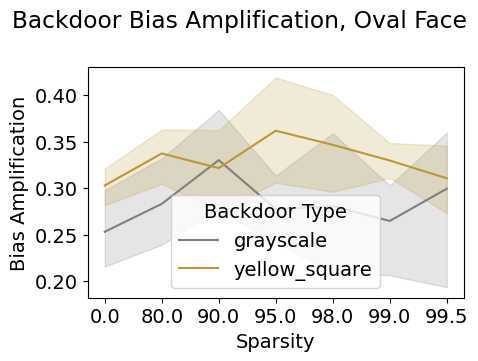

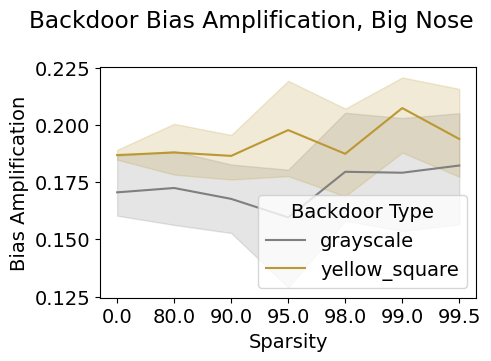

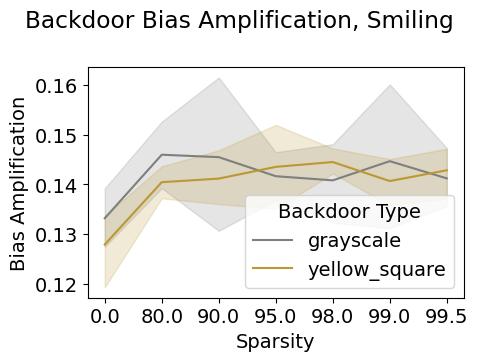

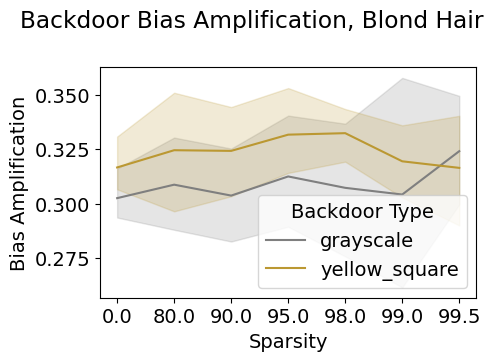

In [32]:
targets = runs_joint.get_test_labels(dataset)

def compute_metric(metric_name, runs, attr_id = None):
    dicts = []
    for run in runs:
        if "test_outputs" not in run:
            print(f"!!!! Dropping run, {run['run_dir']}")
            continue
        if attr_id:
            mydict = {"seed": run["name"], "type": run["type"], "backdoor_type": run["backdoor_type"], "sparsity": str(run["sparsity"]),
                  metric_name: run[metric_name][attr_id]}
        else:
            mydict = {"seed": run["name"], "type": run["type"], "backdoor_type": run["backdoor_type"], "sparsity": str(run["sparsity"]),
                  metric_name: run[metric_name]}
        dicts.append(mydict)
    df = pd.DataFrame.from_dict(dicts)
    averages_df = df.groupby("type").mean()

    return df, averages_df

def compute_uncertainty_auc_underpredict(run):
    if run["sparsity"] == 995:
        run["sparsity"] = 99.5
    run["test_pred_prob"] = 1/(1 + np.exp(-run["test_outputs"]))
    run["uncertainty"] = (np.abs(run["test_pred_prob"]-0.5) < 0.4).mean()
    run["rare-val-underpredict"] = run["test_predictions"].mean()/targets[:, attrs_dict[attr]].mean()
    return run

backdoor_celeba_stats = {}
for i, (attr, runs) in enumerate(backdoor_runs.items()):
    backdoor_celeba_stats[attr] = {}
    attr_id = attrs_dict[attr]

    runs = [compute_uncertainty_auc_underpredict(run) for run in runs]
    runs.sort(key=lambda x: (x["sparsity"], x['backdoor_type']))
    for metric_name in ["bas"]:
        df, averages_df = compute_metric(metric_name, runs)
        df["run_type"] = "single"
        df.sort_values(by='sparsity', inplace=True)
        df.rename(columns={"sparsity": "Sparsity", "bas": "Bias Amplification",
                            "backdoor_type": "Backdoor Type"}
                  , inplace=True)
        backdoor_celeba_stats[attr] = [df, averages_df]
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3.7))
        sns.lineplot(data=df, x="Sparsity", hue="Backdoor Type", y="Bias Amplification", ax=ax, 
                    palette=[sns.color_palette()[7], sns.color_palette("husl")[1]])
        nice_attr_name = runs_joint.celeba_classes()[attrs_dict[attr]].replace("_", " ")
        fig.suptitle(f"Backdoor Bias Amplification, {nice_attr_name}")
        fig.tight_layout()

    if False:
        os.makedirs("Bias_Paper_Plots/single_label", exist_ok=True)
        plt.savefig(f"Bias_Paper_Plots/single_label/backdoor_ba_{attr}.pdf")
